## Info

Trial runs on examining loan underwriting data...

In [1]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import gc

pd.set_option('max_columns',150)
pd.set_option('max_rows',150)

**We will start with this simpler one...**

In [20]:
df = pd.read_csv('data/loan_data_set.csv')
print(df.shape)
df.head()

(614, 13)


Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [22]:
df.stb.freq(["Loan_Status"])

Loan_Status  count    percent  cumulative_count  cumulative_percent
0           Y    422  68.729642               422           68.729642
1           N    192  31.270358               614          100.000000

In [23]:
for c in df.columns:
    print(c, "="*42)
    tmp = df[c].value_counts(dropna=False)
    print(tmp.head(10))

Loan_ID ==========================================
LP002537    1
LP002731    1
LP001535    1
LP002362    1
LP001014    1
LP001677    1
LP001953    1
LP001279    1
LP001978    1
LP002424    1
Name: Loan_ID, dtype: int64
Gender ==========================================
Male      489
Female    112
NaN        13
Name: Gender, dtype: int64
Married ==========================================
Yes    398
No     213
NaN      3
Name: Married, dtype: int64
Dependents ==========================================
0      345
1      102
2      101
3+      51
NaN     15
Name: Dependents, dtype: int64
Education ==========================================
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
Self_Employed ==========================================
No     500
Yes     82
NaN     32
Name: Self_Employed, dtype: int64
ApplicantIncome ==========================================
2500    9
4583    6
2600    6
6000    6
5000    5
4166    5
3333    5
3750    5
2400    4
8333    4
Name

**These are pretty straightforward.**

### Any Repeats for Loan ID?

In [24]:
df.Loan_ID.nunique(), len(df)

(614, 614)

No.

In [25]:
df.set_index('Loan_ID', inplace=True)

In [26]:
df.head()

Gender Married Dependents     Education Self_Employed  \
Loan_ID                                                          
LP001002   Male      No          0      Graduate            No   
LP001003   Male     Yes          1      Graduate            No   
LP001005   Male     Yes          0      Graduate           Yes   
LP001006   Male     Yes          0  Not Graduate            No   
LP001008   Male      No          0      Graduate            No   

          ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
Loan_ID                                                                      
LP001002             5849                0.0         NaN             360.0   
LP001003             4583             1508.0       128.0             360.0   
LP001005             3000                0.0        66.0             360.0   
LP001006             2583             2358.0       120.0             360.0   
LP001008             6000                0.0       141.0             360.0   

          Credit_History Property_Area Loan_Status  
Loan_ID                                             
LP001002             1.0         Urban           Y  
LP001003             1.0         Rural           N  
LP001005             1.0         Urban           Y  
LP001006             1.0         Urban           Y  
LP001008             1.0         Urban           Y

### Examine the Target...

In [27]:
target = 'LoanAmount'

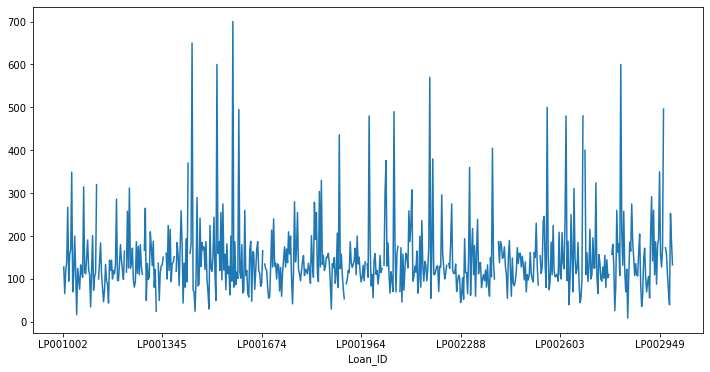

In [28]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
df[target].plot(ax=ax);

In [29]:
print(df.shape)
df = df[~df.LoanAmount.isnull()]
print(df.shape)

(614, 12)
(592, 12)


### Impute Missing Values

Since we are using Regression in this instance, we will create a bin of

In [9]:
def imputer(x, target_col) -> pd.DataFrame:
    '''imputes using most common value or mean over target dist'''
    obj = x.drop(target_col, axis=1).select_dtypes(include='object').columns
    non = x.drop(target_col, axis=1).select_dtypes(exclude='object').columns
    
    for c in obj:
        x[c] = x.groupby(target_col)[c].transform(lambda l: l.fillna(x[c].mode()[0])) #.value_counts().iloc[0]))
        
    for c in non:
        x[c] = x.groupby(target_col)[c].transform(lambda l: l.fillna(x[c].mean()))
        
    return x

In [10]:
df2 = imputer(df, 'Loan_Status')

In [101]:
df2.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Dummying

In [104]:
def dummy_cols(x, target_col) -> pd.DataFrame:
    '''dummies object columns'''
    obj = x.drop(target_col, axis=1).select_dtypes(include='object').columns
    for c in obj:
        tmp = x[c].value_counts(dropna=False)
        if len(tmp) <= 2:
            name = tmp.index[0]
            x[c+'_'+name] = np.where(x[c] == name, 1, 0)
            
        else:
            dum = pd.get_dummies(x[c])
            dum.columns = [c+'_'+d for d in dum.columns]
            x = pd.concat([x, dum], axis=1)
            
    return x.drop(obj, axis=1)

In [107]:
df3 = dummy_cols(df2, 'Loan_Status')

In [108]:
df3.head()

ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
Loan_ID                                                                      
LP001002             5849                0.0  144.294404             360.0   
LP001003             4583             1508.0  128.000000             360.0   
LP001005             3000                0.0   66.000000             360.0   
LP001006             2583             2358.0  120.000000             360.0   
LP001008             6000                0.0  141.000000             360.0   

          Credit_History Loan_Status  Gender_Male  Married_Yes  Dependents_0  \
Loan_ID                                                                        
LP001002             1.0           Y            1            0             1   
LP001003             1.0           N            1            1             0   
LP001005             1.0           Y            1            1             1   
LP001006             1.0           Y            1            1             1   
LP001008             1.0           Y            1            0             1   

          Dependents_1  Dependents_2  Dependents_3+  Education_Graduate  \
Loan_ID                                                                   
LP001002             0             0              0                   1   
LP001003             1             0              0                   1   
LP001005             0             0              0                   1   
LP001006             0             0              0                   0   
LP001008             0             0              0                   1   

          Self_Employed_No  Property_Area_Rural  Property_Area_Semiurban  \
Loan_ID                                                                    
LP001002                 1                    0                        0   
LP001003                 1                    1                        0   
LP001005                 0                    0                        0   
LP001006                 1                    0                        0   
LP001008                 1                    0                        0   

          Property_Area_Urban  
Loan_ID                        
LP001002                    1  
LP001003                    0  
LP001005                    1  
LP001006                    1  
LP001008                    1

### Binarize Target Column

In [109]:
df3['LoanApproved'] = np.where(df3.Loan_Status == 'Y',1,0)
print(df3.LoanApproved.value_counts(),'\n', df3.Loan_Status.value_counts())

1    422
0    192
Name: LoanApproved, dtype: int64 
 Y    422
N    192
Name: Loan_Status, dtype: int64


In [110]:
df3.drop('Loan_Status', axis=1, inplace=True)

## Modeling and Cross Val

At this point we are comfortable with the data as it is and we can move forward with potential modeling.

In [111]:
df3.stb.freq(['LoanApproved'])

LoanApproved  count    percent  cumulative_count  cumulative_percent
0             1    422  68.729642               422           68.729642
1             0    192  31.270358               614          100.000000

**At a ~ 70/30 split we arent going to try and significant rebalancing.**

In [113]:
import shap
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit

import pycaret
from pycaret.classification import *

In [114]:
target = 'LoanApproved'

train, test = train_test_split(df3, test_size=0.3, random_state=123)
print(train.shape, test.shape)

(429, 17) (185, 17)


In [116]:
clf = setup(data=train, target=target, 
            normalize=False, transformation=False, ignore_low_variance=True,
            feature_selection_method='classic', #'boruta',
            n_jobs=3,
#             numeric_features=flist,
            remove_multicollinearity=True, multicollinearity_threshold=0.95,
#             fix_imbalance=True, 
#             fix_imbalance_method=SMOTEENN() #RandomUnderSampler()
            )

In [117]:
top3 = compare_models(n_select=3)

In [118]:
lda = create_model('lda', fold=10)

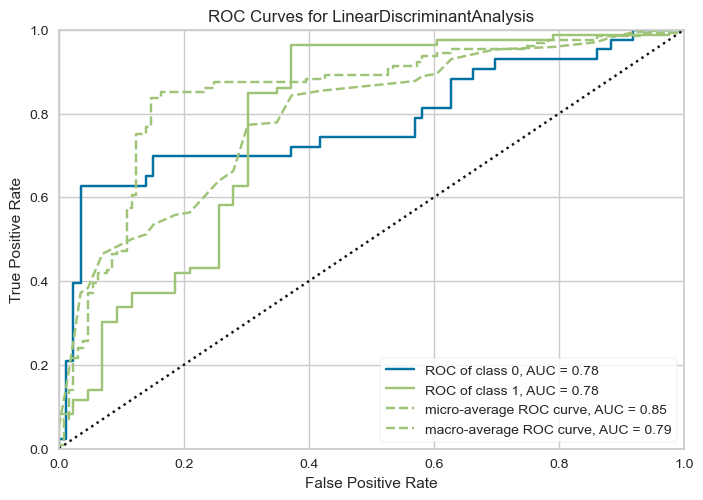

In [119]:
plot_model(lda, plot='auc', scale=1.4)

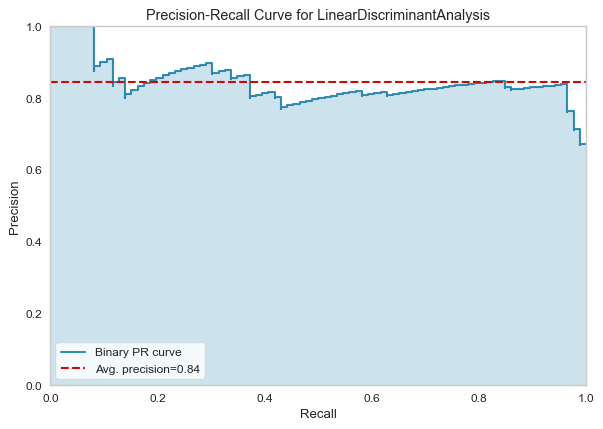

In [120]:
plot_model(lda, 'pr', scale=1.2)

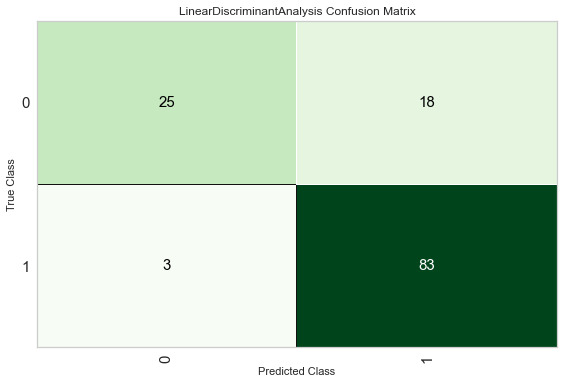

In [121]:
cm = plot_model(lda, 'confusion_matrix')

In [128]:
preds = predict_model(lda, data=test)

probs = pd.DataFrame(lda.predict_proba(test.drop(target,axis=1)), index=test.index, 
                     columns=['N','Y'])
probs.head()

N         Y
Loan_ID                     
LP002898  0.727575  0.272425
LP001027  0.073297  0.926703
LP002422  0.185723  0.814277
LP002418  0.167361  0.832639
LP001882  0.984610  0.015390

In [124]:
# tf = pd.DataFrame(lda.feature_importances_,
#                   index=lda.feature_name_, columns=['imp']).sort_values(by='imp', ascending=False)
# tf.head(10)

In [129]:
print(classification_report(test.LoanApproved, np.round(probs['Y']).astype(int)))

              precision    recall  f1-score   support

           0       0.92      0.52      0.66        64
           1       0.79      0.98      0.87       121

    accuracy                           0.82       185
   macro avg       0.85      0.75      0.77       185
weighted avg       0.84      0.82      0.80       185



1.3503435334464915


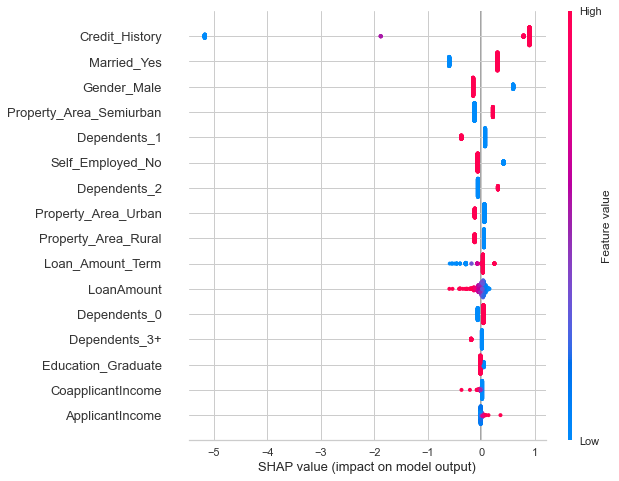

In [135]:
shap_set = train.drop(target, axis=1)
explainer = shap.LinearExplainer(lda, data=train.drop(target, axis=1))
shap_values = explainer.shap_values(shap_set)
print(explainer.expected_value)

shap.summary_plot(shap_values, shap_set)

In [143]:
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(train.drop(target,axis=1).columns,vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
feature_importance

col_name  feature_importance_vals
4            Credit_History                 1.513176
6               Married_Yes                 0.404202
5               Gender_Male                 0.239752
14  Property_Area_Semiurban                 0.159123
8              Dependents_1                 0.122405
12         Self_Employed_No                 0.111419
9              Dependents_2                 0.100947
15      Property_Area_Urban                 0.079509
13      Property_Area_Rural                 0.073487
3          Loan_Amount_Term                 0.067885
2                LoanAmount                 0.058371
7              Dependents_0                 0.050043
10            Dependents_3+                 0.027717
11       Education_Graduate                 0.020836
1         CoapplicantIncome                 0.017163
0           ApplicantIncome                 0.012303

Credit_History


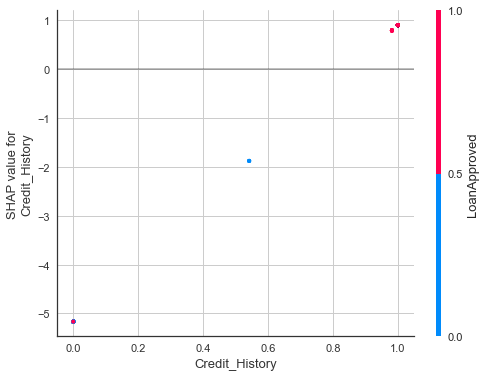

Married_Yes


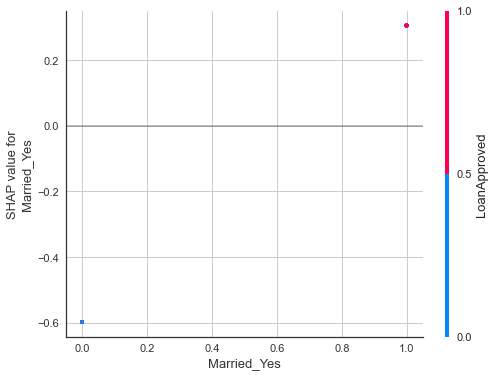

Gender_Male


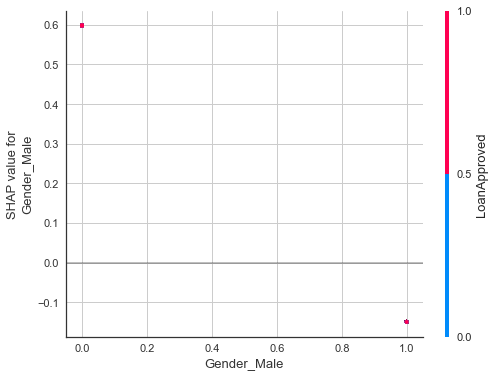

Property_Area_Semiurban


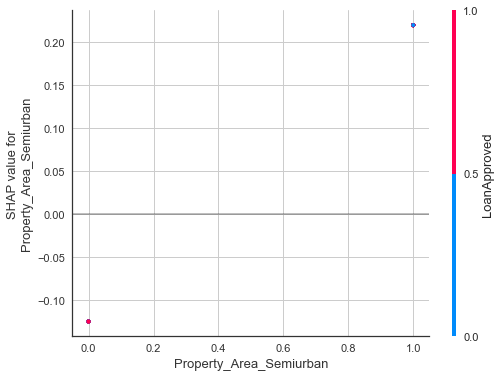

Dependents_1


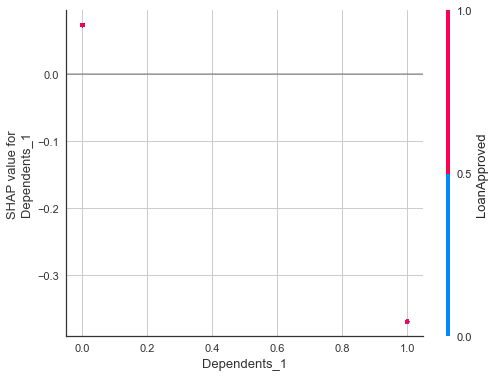

Self_Employed_No


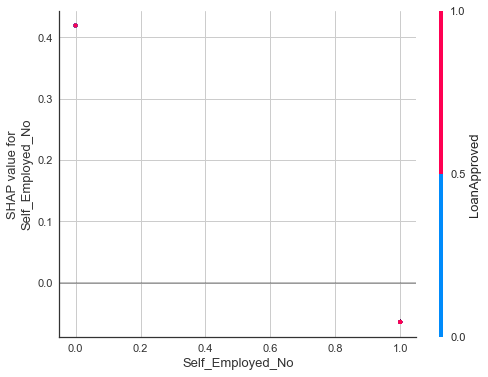

Dependents_2


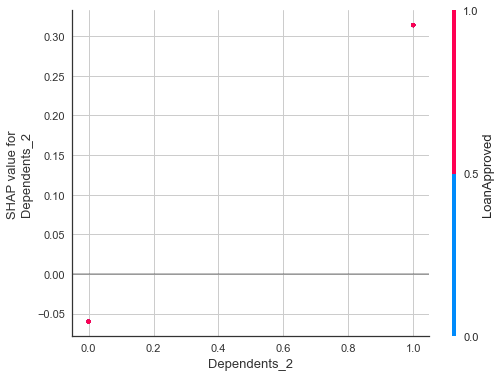

Property_Area_Urban


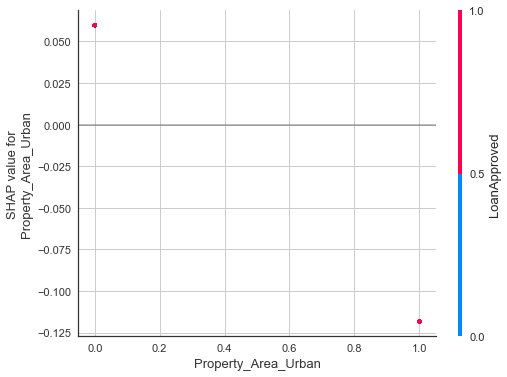

Property_Area_Rural


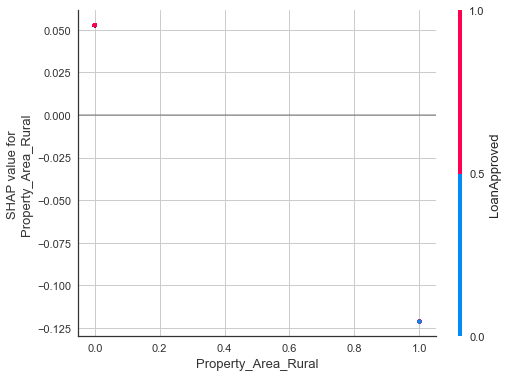

Loan_Amount_Term


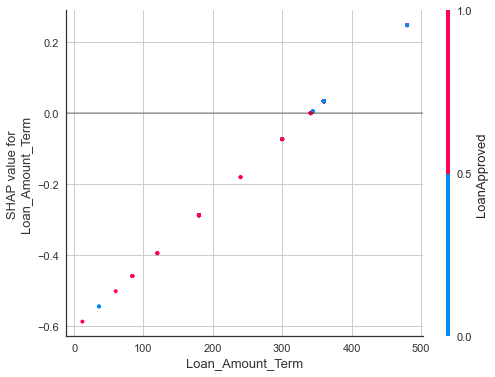

LoanAmount


Dependents_0


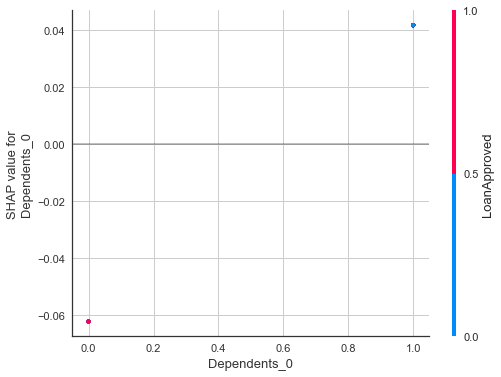

Dependents_3+


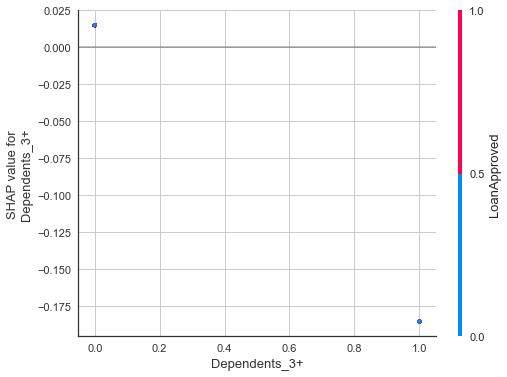

Education_Graduate


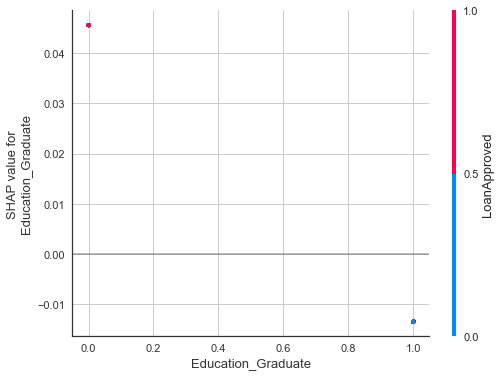

CoapplicantIncome


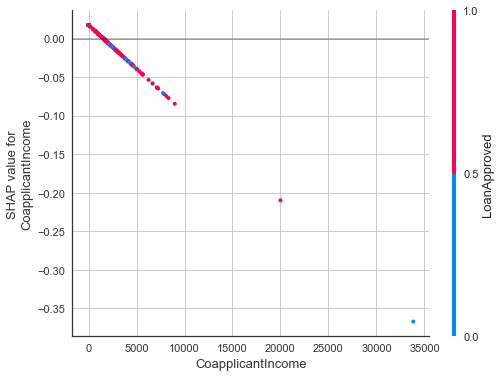

ApplicantIncome


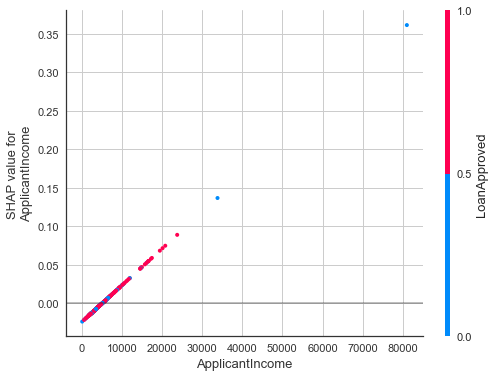

In [146]:
top10feats = feature_importance.col_name
dep_data = train[train.index.isin(shap_set.index)][shap_set.columns.tolist() + [target]]

for item in top10feats:
    print(item)
    fig, ax=plt.subplots(1,1,figsize=(8,6))
    ax.axhline(0, c='k', alpha=0.3);
    shap.dependence_plot(item, 
                         np.hstack([shap_values, np.zeros((len(shap_values), 1))]),
                         dep_data, #pd.concat([bestX, besty], axis=1),
                         interaction_index=target, ax=ax)

In [147]:
train.Credit_History

Loan_ID
LP001367    1.0
LP002517    0.0
LP001398    1.0
LP001318    1.0
LP002820    1.0
           ... 
LP001334    1.0
LP002054    1.0
LP002231    1.0
LP002181    1.0
LP002637    1.0
Name: Credit_History, Length: 429, dtype: float64

**Credit History has such an impact...**

In [148]:
train.Credit_History.value_counts()

1.000000    333
0.000000     61
0.981818     30
0.541899      5
Name: Credit_History, dtype: int64

In [168]:
def hl_pos(s):
    pos = s > 0.5
    return ['background-color: lightgreen' if v else '' for v in pos]

def hl_neg(s):
    neg = s < -0.5
    return ['background-color: salmon' if v else '' for v in neg]

In [172]:
train.corr().style.apply(hl_pos).apply(hl_neg)

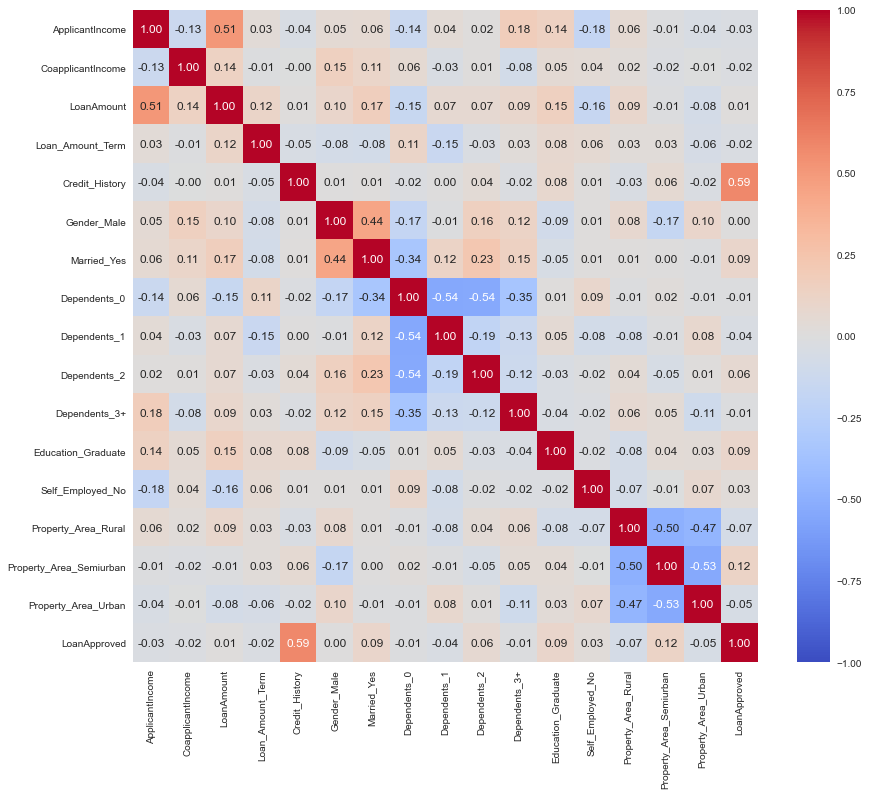

In [175]:
fig, ax=plt.subplots(1,1,figsize=(14,12))
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax);